In [34]:
from typing import Any

import time

from pathlib import Path
import shutil

from datetime import datetime

import yaml

import math
import numpy as np

from PIL import Image, ImageOps
import albumentations as A
import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms


import mlflow
import mlflow.pytorch as ml_pt

from project_modules import (get_new_image_size, get_borders_size, modify_image, prep_images, mlflow_log_figure, create_learning_curves_dict, 
                             ImageModifier, MyResNet34, MyResNet50, ToTensorWithGrad, TargetTransform, TrainingSupervisor)

### Running Mlflow (Run in Ants-Bees-Recognition-Project)

In [35]:
experiment_name = "Ants Bees Recognition Project"

In [36]:
try:
    exp_id = mlflow.create_experiment(name=experiment_name, tags={"Type": "project"})
except:
    exp_id = mlflow.get_experiment_by_name(name=experiment_name).experiment_id

mlflow.set_experiment(experiment_name=experiment_name)
mlflow.set_tracking_uri("/home/maciej/programming/Ants-Bees-Recognition-Project/mlruns/268962542675260621/test-folder")
# mlflow.set_experiment(experiment_id="268962542675260621")

In [37]:
print(mlflow.tracking.get_tracking_uri())

/home/maciej/programming/Ants-Bees-Recognition-Project/mlruns/268962542675260621/test-folder


### Check some image properties

In [38]:
data_path = Path("hymenoptera_data")

path_train = data_path/"train"
path_val = data_path/"val"
path_test = data_path/"test"

path_train_mod = data_path/"train_mod"
path_val_mod = data_path/"val_mod"
path_test_mod = data_path/"test_mod"

path_train_bees = path_train/"bees"
path_train_ants = path_train/"ants"
path_val_bees = path_val/"bees"
path_val_ants = path_val/"ants"
path_test_bees = path_test/"bees"
path_test_ants = path_test/"ants"

path_train_bees_mod = data_path/"train_mod"/"bees"
path_train_ants_mod = data_path/"train_mod"/"ants"
path_val_bees_mod = data_path/"val_mod"/"bees"
path_val_ants_mod = data_path/"val_mod"/"ants"
path_test_bees_mod = data_path/"test_mod"/"bees"
path_test_ants_mod = data_path/"test_mod"/"ants"

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
max_w = 0
max_h = 0
min_w = math.inf
min_h = math.inf

for im_path in path_train_bees.iterdir():
    im = Image.open(im_path)
    w, h = im.size
    max_w = w if w > max_w else max_w
    max_h = h if h > max_h else max_h
    min_w = w if w < min_w else min_w
    min_h = h if h < min_h else min_h
    if w != 500 and h != 500:
        print(im_path)
print(f"max width: {max_w}, max height: {max_h}")
print(f"min width: {min_w}, min height: {min_h}")

hymenoptera_data/train/bees/90.jpeg
hymenoptera_data/train/bees/100.jpeg
hymenoptera_data/train/bees/97.jpeg
hymenoptera_data/train/bees/89.jpeg
hymenoptera_data/train/bees/88.jpeg
hymenoptera_data/train/bees/92.jpeg
hymenoptera_data/train/bees/2610833167_79bf0bcae5.jpg
hymenoptera_data/train/bees/98.jpeg
hymenoptera_data/train/bees/99.jpeg
hymenoptera_data/train/bees/2781170484_5d61835d63.jpg
hymenoptera_data/train/bees/10.jpeg
hymenoptera_data/train/bees/94.jpeg
hymenoptera_data/train/bees/95.jpeg
hymenoptera_data/train/bees/96.jpeg
hymenoptera_data/train/bees/91.jpeg
hymenoptera_data/train/bees/93.jpeg
max width: 500, max height: 500
min width: 245, min height: 168


In [41]:
im_path1 = path_train_bees/"2610833167_79bf0bcae5.jpg"
im_path2 = path_train_bees/"2781170484_5d61835d63.jpg"
im_path3 = "hymenoptera_data/val/ants/43.jpeg"

im1 = Image.open(im_path1)
im2 = Image.open(im_path2)
im3 = Image.open(im_path3)

In [42]:
im1.width, im1.height

(311, 387)

In [43]:
im2.width, im2.height

(486, 429)

214 95


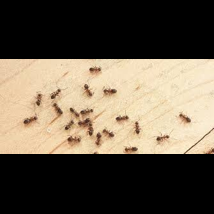

In [44]:
image_mod = modify_image(image=im3)
image_mod

### Prepare images

In [45]:
# image_modifier = ImageModifier(desired_wh=224)
# im_mod = image_modifier.modify_image(image=im3, add_borders=False)
# im_mod

In [46]:
# image_modifier = ImageModifier(desired_wh=224)

# alb_trans = A.Compose([
#                     #    A.Resize(width=250, height=250), 
#                     #    A.RandomCrop(width=214, height=214), 
#                        A.Rotate(limit=40, p=0.1, border_mode=cv2.BORDER_CONSTANT), 
#                        A.HorizontalFlip(p=0.5),
#                        A.VerticalFlip(p=0.05), 
#                        A.Blur(blur_limit=3, p=0.05), 
#                        A.OneOf([
#                                 # A.ColorJitter(p=0.5),
#                                 A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)
#                                 ], p=1.0)
#                        ])


# original_files_dirs = [path_train_bees, path_train_ants]
# modified_files_dirs = [path_train_bees_mod, path_train_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier, alb_trans, True)

# original_files_dirs = [path_val_bees, path_val_ants]
# modified_files_dirs = [path_val_bees_mod, path_val_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier)

# original_files_dirs = [path_test_bees, path_test_ants]
# modified_files_dirs = [path_test_bees_mod, path_test_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier)

### Show exapmle of modified image

In [47]:
# Use this to experiment with some other albumentations transforms
# # alb_trans = A.Compose([A.Resize(width=250, height=250), 
# #                        A.RandomCrop(width=214, height=214), 
# #                        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT), 
# #                        A.HorizontalFlip(p=0.5),
# #                        A.VerticalFlip(p=0.05), 
# #                        A.OneOf([
# #                                 A.Blur(blur_limit=3), 
# #                                 A.ColorJitter(p=0.5),
# #                                 A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25)
# #                                 ], p=1.0)
# #                        ])


# mod_bee_path = path_train_bees/"16838648_415acd9e3f.jpg"
# mod_bee = Image.open(mod_bee_path)
# mod_bee = image_modifier.modify_image(image=mod_bee, add_borders=False)
# mod_bee = np.array(mod_bee)
# mod_bee = alb_trans(image=mod_bee)
# mod_bee = mod_bee["image"]
# plt.imshow(mod_bee)
# plt.show()

### Prepare Pytorch datasets and dataloaders

In [48]:
# The same as transforms.ToTensor() but sets requires_grad == True
dataset_transform = ToTensorWithGrad()
# dataset_transform = transforms.ToTensor()

# train_dataset = ImageFolder(root=path_train_mod, transform=dataset_transform, target_transform=TargetTransform())
train_dataset = ImageFolder(root=path_train_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
val_dataset = ImageFolder(root=path_val_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [49]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(68, 6, 5)

In [50]:
len(train_dataloader.dataset)

2168

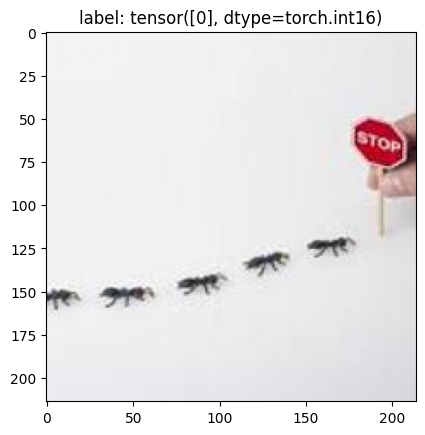

In [51]:
batch = (next(iter(val_dataloader)))
test_picture = batch[0][0].detach().numpy()
test_label = batch[1][0].short()
test_picture = np.transpose(test_picture, axes=(1, 2, 0))
plt.imshow(test_picture)
plt.title(f"label: {test_label}")
plt.show()

### Check dataloaders

In [52]:
# X, y = next(iter(train_dataloader))
# outputs = my_resnet(X)
# outputs.shape, y.shape

In [53]:
# labels = torch.tensor([[1]*32], dtype=torch.float).T
# loss_fn = nn.BCEWithLogitsLoss()
# loss = loss_fn(outputs, labels)
# loss

### Check TrainingSupervisor class

In [54]:
# path=Path("./checkpoints/checkpoint.pth")
# model=MyResNet34().to(device)
# supervisor = TrainingSupervisor(model=model, early_stop_patience=5, lr=0.01, lr_patience=2, lr_reduce_factor = 2, checkpoints_default_filepath=path)
# supervisor.save_model_state_dict()

### Check the model - try overfitting single training minibatch and logging the results to mlflow

In [55]:
# batch_size = 1

# # dataset_transform = transforms.ToTensor()
# dataset_transform = ToTensorWithGrad()

# train_dataset = ImageFolder(root=path_train_mod, transform=dataset_transform, target_transform=TargetTransform())
# val_dataset = ImageFolder(root=path_val_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
# test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())

In [56]:
# model = MyResNet50()
# model.to(device)
# path=Path("./checkpoints/checkpoint.pth")
# lr = 0.01
# supervisor = TrainingSupervisor(model=model, early_stop_patience=3, lr=lr, lr_patience=2, lr_reduce_factor = 2, checkpoints_default_filepath=path)
# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [57]:
# n_epochs = 20
# batch_size = 14

# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# plots_x_axis = np.array([])
# training_losses = np.array([])
# validation_losses = np.array([])
# accuracies = np.array([])
# learning_rates = np.array([])



# batch = (next(iter(train_dataloader)))
# X, y = batch[0], batch[1]
# X, y = X.to(device), y.to(device)


# with mlflow.start_run() as run:
#     run_id = run.info.run_id
#     for epoch in range(1, n_epochs+1):
#         print(f"\nEpoch {epoch}/{n_epochs}")
# # ========================================================================
#         outputs = model(X)
#         loss = loss_fn(outputs, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# # ========================================================================

#         print(f"Training loss: {loss:.2f}")

### Check the model performance, perform full training and evaluating scenario

In [58]:
# loaded_state_dict = ml_pt.load_state_dict(state_dict_uri="mlruns/268962542675260621/f74e570265ba4458b5c8afd25ecd02ce/artifacts/model_artifacts")
# model = MyResNet34()
# model.load_state_dict(state_dict=loaded_state_dict)

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet50()

In [59]:
path=Path("./checkpoints/checkpoint.pth")
lr = 0.01
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=lr, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [60]:
n_epochs = 1000

batch_size = 26
if model._get_name() == "MyResNet34":
    batch_size = 26
elif model._get_name() == "MyResNet50":
    batch_size = 12
    
model.to(device)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
len_dataloader = len(train_dataloader)

epochs = np.array([])
train_losses = np.array([])
val_losses = np.array([])
train_accuracies = np.array([])
val_accuracies = np.array([])
learning_rates = np.array([])

ml_pt.autolog(disable=False)
try:
    with mlflow.start_run() as run:
        params_dict = {"Model architecture": model._get_name(), "Batch size": batch_size, 
                       "Train dataset size": len(train_dataloader.dataset), 
                       "Validation dataset size": len(val_dataloader.dataset), "No. of augmentations per image": 3}
        mlflow.log_params(params=params_dict)
        run_id = run.info.run_id
        for epoch in range(1, n_epochs+1):
            print(f"\nEpoch {epoch}/{n_epochs}")
    # ========================================================================
            for idx, (X, y) in enumerate(train_dataloader):
                print(f"Step {idx + 1}/{len_dataloader}")
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = loss_fn(outputs, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # ========================================================================
            print("Evaluating model performance...")
            train_accuracy, train_loss_sum = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=train_dataloader, device=device)
            val_accuracy, val_loss_sum = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=val_dataloader, device=device)

            lr = supervisor.lr

            mlflow.log_metrics(metrics={"Epoch": epoch, "Training loss": train_loss_sum, 
                                        "Validaion loss": val_loss_sum, "Training accuracy": train_accuracy, 
                                        "Validation accuracy": val_accuracy, "Learning rate": lr})

            epochs = np.append(epochs, epoch)
            train_losses = np.append(train_losses, train_loss_sum)
            val_losses = np.append(val_losses, val_loss_sum)
            train_accuracies = np.append(train_accuracies, train_accuracy)
            val_accuracies = np.append(val_accuracies, val_accuracy)
            learning_rates = np.append(learning_rates, lr)

            mlflow_log_figure(X=epochs, Y=train_losses, artifact_file="learning_curves.png", 
                            Y2=val_losses, title="learning curves", xlabel="epoch", 
                            ylabel="loss values", legend=["train loss", "val loss"])
            
            mlflow_log_figure(X=epochs, Y=train_accuracies, artifact_file="plots/accuracies.png", 
                                Y2=val_accuracies, title="training and validation accuracies", xlabel="epoch", 
                                ylabel="accuracy", legend=["training accuracy", "validation accuracy"])

            mlflow_log_figure(X=epochs, Y=learning_rates, artifact_file="plots/learning_rate.png", 
                        title="learning rate", xlabel="epoch", ylabel="lr")
            
            print("\n")
            print(f"Training accuracy: {train_accuracy:.2f}%")
            print(f"Validation accuracy: {val_accuracy:.2f}%")
            print(f"Training loss: {train_loss_sum:.5f}")
            print(f"Validation loss: {val_loss_sum:.5f}")
            print(f"lr: {lr}")
            
            save_state_dict = supervisor.update_patience_counters(current_val_loss=val_loss_sum)
            early_stop = supervisor.early_stop()

            new_lr = supervisor.update_lr()
            optimizer.param_groups[0]['lr'] = new_lr

            if save_state_dict:
                supervisor.mlflow_save_model_state_dict(artifact_path="model_artifacts")
                mlflow.log_metric(key="Number of checkpoints", value=supervisor.mlflow_model_checkpoints_saved)

            elif early_stop:
                learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
                mlflow.set_tag(key="Exited by", value="Early Stop")
                mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json")
                break
        if not early_stop:
            print("Finished all epochs")
            learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
            mlflow.set_tag(key="Exited by", value="Finished all epochs")
            mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json")

# Log the metadata in case of keyboard interrupt or other error
except KeyboardInterrupt:
    print("Keyboard Interrupt occurred")
    learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
    mlflow.start_run(run_id=run_id, experiment_id=exp_id)
    mlflow.set_tag(key="Exited by", value="Keyboard Interrupt")
    mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json", run_id=run_id)
    mlflow.end_run(status="FINISHED")

except RuntimeError as e:
    if "out of memory" in str(e):
        learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
        print("Out of Memory Error")
        mlflow.start_run(run_id=run_id, experiment_id=exp_id)
        mlflow.set_tag(key="Exited by", value="Out of Memory Error")
        mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json", run_id=run_id)
        mlflow.end_run(status="FAILED")

2024/09/29 21:45:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.



Epoch 1/1000
Step 1/181
Step 2/181
Step 3/181
Step 4/181
Step 5/181
Step 6/181
Step 7/181
Step 8/181
Step 9/181
Step 10/181
Step 11/181
Step 12/181
Step 13/181
Step 14/181
Step 15/181
Step 16/181
Step 17/181
Step 18/181
Step 19/181
Step 20/181
Step 21/181
Step 22/181
Step 23/181
Step 24/181
Step 25/181
Step 26/181
Step 27/181
Step 28/181
Step 29/181
Step 30/181
Step 31/181
Step 32/181
Step 33/181
Step 34/181
Step 35/181
Step 36/181
Step 37/181
Step 38/181
Step 39/181
Step 40/181
Step 41/181
Step 42/181
Step 43/181
Step 44/181
Step 45/181
Step 46/181
Step 47/181
Step 48/181
Step 49/181
Step 50/181
Step 51/181
Step 52/181
Step 53/181
Step 54/181
Step 55/181
Step 56/181
Step 57/181
Step 58/181
Step 59/181
Step 60/181
Step 61/181
Step 62/181
Step 63/181
Step 64/181
Step 65/181
Step 66/181
Step 67/181
Step 68/181
Step 69/181
Step 70/181
Step 71/181
Step 72/181
Step 73/181
Step 74/181
Step 75/181
Step 76/181
Step 77/181
Step 78/181
Step 79/181
Step 80/181
Step 81/181
Step 82/181
Step 83/181

In [27]:
mlflow.end_run(status="FINISHED")

In [33]:
print(mlflow.get_tracking_uri())

/home/maciej/programming/Ants-Bees-Recognition-Project/mlruns/268962542675260621/test-folder
